In [1]:
import csv 
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis/Battery')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
#sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis/Battery')
from battery import OCVcurve, Thevenin
import analog
from scipy.interpolate import interp1d as interp1d
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

### Import the equivalent circuit parameters

In [2]:
ECparams = pd.read_csv('ECparams.csv')
R0 = float(ECparams['R0'])
R0 = 0.005
R1 = float(ECparams['R1'])
R1 = 0.01
C1 = float(ECparams['C1'])
C1 = 566.666

In [16]:
curve = OCVcurve('Battery 9/Discharge 200mA/SOCvsOCV_discharge200mA.csv')
curve.plot()
z0 = 1
a = curve.getslope(z0)
b = curve.OCVfromSOC(z0)-a*z0
x = np.array([0,1])
plt.plot(a*x+b)
plt.plot(z0,curve.OCVfromSOC(z0),'rx')

TypeError: plot() missing 1 required positional argument: 'ys'

# Simulation

### Import the test file

In [17]:
folder = '/home/lucas/Documents/Log_Analysis/Logs/Snow Orange (Battery 9) z0=1'
#folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs'
log_file = analog.pathfromQGC(folder,index=195)

print(log_file)
info = analog.logextract(log_file,'battery_status')

current = info['battery_current']
time = info['time_bs']
voltage = info['battery_voltage']/4

/home/lucas/Documents/Log_Analysis/Logs/Snow Orange (Battery 9) z0=1/log_195_2019-9-26-14-05-18.ulg


### Tune some more simulation parameters

In [43]:
Q = 6230*3.6 # has to be in Coulombs
Q = 8000*3.6
eta = 1
z0 = curve.SOCfromOCV(np.mean(voltage[0])+R0*current[0]) # taken from log to be tested
print(f'z0 = {z0}')
battery = Thevenin(z0,Q,curve,R0,R1,C1)

z0 = 0.9844921997048863


In [44]:
print(f'True measured initital voltage is {voltage[0]:.2f} V')
print(f'True initial OCV would then be {voltage[0]+R0*current[0]:.2f} V, because initial current is {current[0]:.2f} A')

True measured initital voltage is 4.30 V
True initial OCV would then be 4.30 V, because initial current is 0.00 A


### Run the simulation using the state-space model

<IPython.core.display.Javascript object>


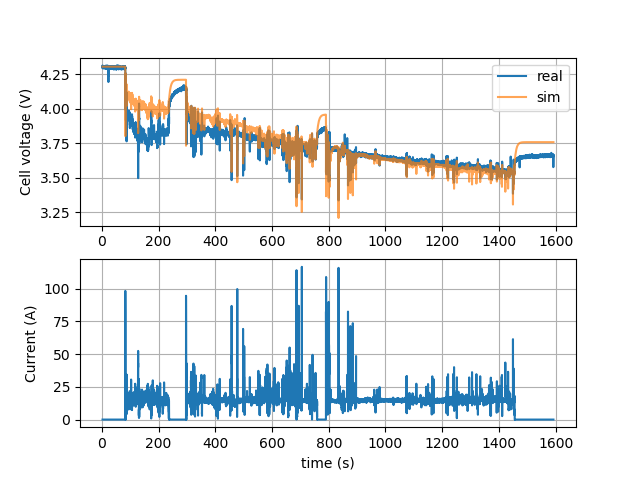

In [45]:
%matplotlib notebook
vsim = battery.simulate(time,current,plot=False)
battery.statespace(np.mean(np.diff(time)))
vlsim = battery.lsim(time,current,curve)

plt.figure()
plt.subplot(211)
plt.plot(time,voltage,label='real')
plt.plot(time,vsim,label='sim',alpha=.7)
#plt.plot(time,vlsim+3.6,label='linsim')
plt.legend()
plt.grid()
plt.ylabel('Cell voltage (V)')
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('Current (A)')
plt.grid()
plt.show()

In [46]:
N = len(vsim)
rmserror = (1/N*np.sum((vsim-voltage)**2))**.5
print(f'Root mean square error is {round(rmserror*1000,2)} mV. It is acceptable under 10mV according to Prof. G.Plett.')

Root mean square error is 78.36 mV. It is acceptable under 10mV according to Prof. G.Plett.


In [33]:
n=20
R0list = np.array(np.linspace(0,15,n))*1e-3
R1list = np.array(np.linspace(0,15,n))*1e-3
C1list = np.array(np.linspace(100,1500,n))

sk = np.empty_like([],shape=[len(R0list),len(R1list),len(C1list)])
print(np.shape(sk))

batsim = Thevenin(z0,Q,curve,R0list[0],R1list[0],C1list[0])
print(z0)

(20, 20, 20)
0.9844921997048863


In [11]:
current_iteration = 0
max_iteration = n*n*n-1
for kr0 in range(len(R0list)):
    for kr in range(len(R1list)):
        for kc in range(len(C1list)):
            progress = current_iteration / max_iteration
            print(f'progress: {progress*100} % \r')
            current_iteration += 1
            batsim.reset(R0list[kr0],R1list[kr],C1list[kc],z0)
            vsim = batsim.simulate(time,current)
            rms = (np.mean((voltage-vsim)**2))**.5
            sk[kr0,kr,kc] = rms

(20, 20, 20)
progress: 0.0 % 


/home/lucas/Documents/Log_Analysis/Battery/battery.py:244: RuntimeWarning: divide by zero encountered in double_scalars
  self.simi1.append(np.exp(-self.simdt/(self.R1*self.C1)) * self.simi1[k] + (1 - np.exp(-self.simdt/(self.R1*self.C1)))*self.simi[k])


progress: 0.012501562695336917 % 
progress: 0.025003125390673835 % 
progress: 0.037504688086010755 % 
progress: 0.05000625078134767 % 
progress: 0.06250781347668459 % 
progress: 0.07500937617202151 % 
progress: 0.08751093886735842 % 
progress: 0.10001250156269534 % 
progress: 0.11251406425803225 % 
progress: 0.12501562695336918 % 
progress: 0.1375171896487061 % 
progress: 0.15001875234404302 % 
progress: 0.16252031503937991 % 
progress: 0.17502187773471684 % 
progress: 0.18752344043005376 % 
progress: 0.20002500312539068 % 
progress: 0.2125265658207276 % 
progress: 0.2250281285160645 % 
progress: 0.23752969121140144 % 
progress: 0.25003125390673836 % 
progress: 0.2625328166020752 % 
progress: 0.2750343792974122 % 
progress: 0.28753594199274907 % 
progress: 0.30003750468808604 % 
progress: 0.3125390673834229 % 
progress: 0.32504063007875983 % 
progress: 0.3375421927740968 % 
progress: 0.35004375546943367 % 
progress: 0.3625453181647706 % 
progress: 0.3750468808601075 % 
progress: 0.3875

progress: 3.2379047380922614 % 
progress: 3.2504063007875983 % 
progress: 3.2629078634829356 % 
progress: 3.2754094261782725 % 
progress: 3.2879109888736093 % 
progress: 3.3004125515689458 % 
progress: 3.312914114264283 % 
progress: 3.32541567695962 % 
progress: 3.337917239654957 % 
progress: 3.350418802350294 % 
progress: 3.362920365045631 % 
progress: 3.3754219277409674 % 
progress: 3.3879234904363043 % 
progress: 3.4004250531316416 % 
progress: 3.4129266158269784 % 
progress: 3.4254281785223153 % 
progress: 3.4379297412176526 % 
progress: 3.450431303912989 % 
progress: 3.462932866608326 % 
progress: 3.4754344293036628 % 
progress: 3.487935991999 % 
progress: 3.500437554694337 % 
progress: 3.5129391173896742 % 
progress: 3.52544068008501 % 
progress: 3.5379422427803475 % 
progress: 3.5504438054756844 % 
progress: 3.5629453681710213 % 
progress: 3.5754469308663586 % 
progress: 3.5879484935616954 % 
progress: 3.600450056257032 % 
progress: 3.6129516189523687 % 
progress: 3.625453181647

progress: 6.538317289661208 % 
progress: 6.550818852356545 % 
progress: 6.563320415051882 % 
progress: 6.575821977747219 % 
progress: 6.588323540442555 % 
progress: 6.6008251031378915 % 
progress: 6.613326665833228 % 
progress: 6.625828228528566 % 
progress: 6.638329791223903 % 
progress: 6.65083135391924 % 
progress: 6.663332916614577 % 
progress: 6.675834479309914 % 
progress: 6.688336042005251 % 
progress: 6.700837604700588 % 
progress: 6.713339167395925 % 
progress: 6.725840730091262 % 
progress: 6.738342292786598 % 
progress: 6.750843855481935 % 
progress: 6.763345418177272 % 
progress: 6.7758469808726085 % 
progress: 6.788348543567945 % 
progress: 6.800850106263283 % 
progress: 6.81335166895862 % 
progress: 6.825853231653957 % 
progress: 6.838354794349294 % 
progress: 6.850856357044631 % 
progress: 6.863357919739968 % 
progress: 6.875859482435305 % 
progress: 6.88836104513064 % 
progress: 6.900862607825978 % 
progress: 6.913364170521315 % 
progress: 6.925865733216652 % 
progress:

progress: 9.863732966620828 % 
progress: 9.876234529316164 % 
progress: 9.888736092011502 % 
progress: 9.901237654706838 % 
progress: 9.913739217402174 % 
progress: 9.926240780097512 % 
progress: 9.938742342792848 % 
progress: 9.951243905488186 % 
progress: 9.963745468183523 % 
progress: 9.97624703087886 % 
progress: 9.988748593574197 % 
progress: 10.001250156269533 % 
progress: 10.01375171896487 % 
progress: 10.026253281660209 % 
progress: 10.038754844355545 % 
progress: 10.051256407050882 % 
progress: 10.063757969746218 % 
progress: 10.076259532441554 % 
progress: 10.088761095136892 % 
progress: 10.101262657832228 % 
progress: 10.113764220527566 % 
progress: 10.126265783222903 % 
progress: 10.13876734591824 % 
progress: 10.151268908613577 % 
progress: 10.163770471308913 % 
progress: 10.176272034004251 % 
progress: 10.188773596699589 % 
progress: 10.201275159394925 % 
progress: 10.21377672209026 % 
progress: 10.226278284785598 % 
progress: 10.238779847480934 % 
progress: 10.2512814101

progress: 13.089136142017752 % 
progress: 13.10163770471309 % 
progress: 13.114139267408426 % 
progress: 13.126640830103764 % 
progress: 13.1391423927991 % 
progress: 13.151643955494437 % 
progress: 13.164145518189773 % 
progress: 13.17664708088511 % 
progress: 13.189148643580447 % 
progress: 13.201650206275783 % 
progress: 13.214151768971123 % 
progress: 13.226653331666457 % 
progress: 13.239154894361796 % 
progress: 13.251656457057132 % 
progress: 13.26415801975247 % 
progress: 13.276659582447806 % 
progress: 13.289161145143144 % 
progress: 13.30166270783848 % 
progress: 13.314164270533816 % 
progress: 13.326665833229153 % 
progress: 13.33916739592449 % 
progress: 13.351668958619827 % 
progress: 13.364170521315163 % 
progress: 13.376672084010503 % 
progress: 13.389173646705837 % 
progress: 13.401675209401176 % 
progress: 13.414176772096512 % 
progress: 13.42667833479185 % 
progress: 13.439179897487186 % 
progress: 13.451681460182524 % 
progress: 13.46418302287786 % 
progress: 13.4766

progress: 16.314539317414678 % 
progress: 16.327040880110015 % 
progress: 16.33954244280535 % 
progress: 16.352044005500687 % 
progress: 16.364545568196025 % 
progress: 16.377047130891363 % 
progress: 16.389548693586697 % 
progress: 16.402050256282035 % 
progress: 16.414551818977372 % 
progress: 16.42705338167271 % 
progress: 16.439554944368044 % 
progress: 16.452056507063382 % 
progress: 16.46455806975872 % 
progress: 16.477059632454058 % 
progress: 16.489561195149392 % 
progress: 16.50206275784473 % 
progress: 16.514564320540067 % 
progress: 16.5270658832354 % 
progress: 16.539567445930743 % 
progress: 16.552069008626077 % 
progress: 16.564570571321415 % 
progress: 16.577072134016753 % 
progress: 16.58957369671209 % 
progress: 16.602075259407425 % 
progress: 16.614576822102762 % 
progress: 16.6270783847981 % 
progress: 16.639579947493438 % 
progress: 16.652081510188772 % 
progress: 16.66458307288411 % 
progress: 16.677084635579448 % 
progress: 16.68958619827478 % 
progress: 16.702087

progress: 19.564945618202277 % 
progress: 19.57744718089761 % 
progress: 19.58994874359295 % 
progress: 19.602450306288286 % 
progress: 19.614951868983624 % 
progress: 19.62745343167896 % 
progress: 19.6399549943743 % 
progress: 19.652456557069634 % 
progress: 19.66495811976497 % 
progress: 19.67745968246031 % 
progress: 19.689961245155644 % 
progress: 19.70246280785098 % 
progress: 19.71496437054632 % 
progress: 19.727465933241657 % 
progress: 19.73996749593699 % 
progress: 19.75246905863233 % 
progress: 19.764970621327667 % 
progress: 19.777472184023004 % 
progress: 19.78997374671834 % 
progress: 19.802475309413676 % 
progress: 19.814976872109014 % 
progress: 19.82747843480435 % 
progress: 19.839979997499686 % 
progress: 19.852481560195024 % 
progress: 19.86498312289036 % 
progress: 19.877484685585696 % 
progress: 19.889986248281037 % 
progress: 19.90248781097637 % 
progress: 19.91498937367171 % 
progress: 19.927490936367047 % 
progress: 19.939992499062384 % 
progress: 19.95249406175

progress: 22.802850356294538 % 
progress: 22.815351918989872 % 
progress: 22.82785348168521 % 
progress: 22.840355044380548 % 
progress: 22.852856607075882 % 
progress: 22.86535816977122 % 
progress: 22.877859732466558 % 
progress: 22.890361295161895 % 
progress: 22.90286285785723 % 
progress: 22.91536442055257 % 
progress: 22.927865983247905 % 
progress: 22.940367545943243 % 
progress: 22.95286910863858 % 
progress: 22.96537067133392 % 
progress: 22.977872234029252 % 
progress: 22.99037379672459 % 
progress: 23.002875359419928 % 
progress: 23.015376922115262 % 
progress: 23.0278784848106 % 
progress: 23.040380047505938 % 
progress: 23.052881610201275 % 
progress: 23.06538317289661 % 
progress: 23.07788473559195 % 
progress: 23.090386298287285 % 
progress: 23.102887860982623 % 
progress: 23.11538942367796 % 
progress: 23.1278909863733 % 
progress: 23.140392549068633 % 
progress: 23.15289411176397 % 
progress: 23.165395674459308 % 
progress: 23.177897237154642 % 
progress: 23.1903987998

progress: 26.053256657082137 % 
progress: 26.065758219777475 % 
progress: 26.078259782472806 % 
progress: 26.090761345168147 % 
progress: 26.103262907863485 % 
progress: 26.115764470558823 % 
progress: 26.128266033254157 % 
progress: 26.140767595949495 % 
progress: 26.153269158644832 % 
progress: 26.16577072134017 % 
progress: 26.178272284035504 % 
progress: 26.190773846730842 % 
progress: 26.20327540942618 % 
progress: 26.215776972121514 % 
progress: 26.22827853481685 % 
progress: 26.24078009751219 % 
progress: 26.253281660207527 % 
progress: 26.26578322290286 % 
progress: 26.2782847855982 % 
progress: 26.290786348293537 % 
progress: 26.303287910988875 % 
progress: 26.31578947368421 % 
progress: 26.328291036379547 % 
progress: 26.340792599074884 % 
progress: 26.35329416177022 % 
progress: 26.365795724465556 % 
progress: 26.378297287160894 % 
progress: 26.390798849856235 % 
progress: 26.403300412551566 % 
progress: 26.415801975246904 % 
progress: 26.428303537942245 % 
progress: 26.4408

progress: 29.303662957869737 % 
progress: 29.316164520565067 % 
progress: 29.32866608326041 % 
progress: 29.341167645955746 % 
progress: 29.353669208651077 % 
progress: 29.366170771346418 % 
progress: 29.378672334041756 % 
progress: 29.391173896737094 % 
progress: 29.403675459432428 % 
progress: 29.416177022127766 % 
progress: 29.428678584823103 % 
progress: 29.44118014751844 % 
progress: 29.453681710213775 % 
progress: 29.466183272909113 % 
progress: 29.47868483560445 % 
progress: 29.49118639829979 % 
progress: 29.503687960995123 % 
progress: 29.51618952369046 % 
progress: 29.5286910863858 % 
progress: 29.541192649081133 % 
progress: 29.55369421177647 % 
progress: 29.566195774471808 % 
progress: 29.57869733716715 % 
progress: 29.59119889986248 % 
progress: 29.603700462557818 % 
progress: 29.61620202525316 % 
progress: 29.628703587948497 % 
progress: 29.641205150643827 % 
progress: 29.65370671333917 % 
progress: 29.666208276034506 % 
progress: 29.678709838729837 % 
progress: 29.6912114

progress: 32.55406925865733 % 
progress: 32.56657082135267 % 
progress: 32.57907238404801 % 
progress: 32.59157394674334 % 
progress: 32.60407550943868 % 
progress: 32.61657707213402 % 
progress: 32.629078634829355 % 
progress: 32.64158019752469 % 
progress: 32.65408176022003 % 
progress: 32.666583322915365 % 
progress: 32.6790848856107 % 
progress: 32.69158644830604 % 
progress: 32.704088011001375 % 
progress: 32.716589573696716 % 
progress: 32.72909113639205 % 
progress: 32.741592699087384 % 
progress: 32.754094261782726 % 
progress: 32.76659582447806 % 
progress: 32.779097387173394 % 
progress: 32.791598949868735 % 
progress: 32.80410051256407 % 
progress: 32.81660207525941 % 
progress: 32.829103637954745 % 
progress: 32.84160520065008 % 
progress: 32.85410676334542 % 
progress: 32.866608326040755 % 
progress: 32.87910988873609 % 
progress: 32.89161145143143 % 
progress: 32.904113014126764 % 
progress: 32.9166145768221 % 
progress: 32.92911613951744 % 
progress: 32.94161770221278 % 

progress: 35.81697712214027 % 
progress: 35.8294786848356 % 
progress: 35.84198024753094 % 
progress: 35.85448181022628 % 
progress: 35.86698337292161 % 
progress: 35.87948493561695 % 
progress: 35.89198649831229 % 
progress: 35.904488061007626 % 
progress: 35.91698962370296 % 
progress: 35.9294911863983 % 
progress: 35.941992749093636 % 
progress: 35.95449431178898 % 
progress: 35.96699587448431 % 
progress: 35.979497437179646 % 
progress: 35.99199899987499 % 
progress: 36.00450056257032 % 
progress: 36.017002125265655 % 
progress: 36.029503687961 % 
progress: 36.04200525065633 % 
progress: 36.054506813351665 % 
progress: 36.067008376047006 % 
progress: 36.07950993874234 % 
progress: 36.09201150143768 % 
progress: 36.104513064133016 % 
progress: 36.11701462682835 % 
progress: 36.12951618952369 % 
progress: 36.14201775221903 % 
progress: 36.15451931491436 % 
progress: 36.1670208776097 % 
progress: 36.17952244030504 % 
progress: 36.19202400300037 % 
progress: 36.20452556569571 % 
progre

progress: 39.11738967370921 % 
progress: 39.12989123640455 % 
progress: 39.14239279909989 % 
progress: 39.15489436179522 % 
progress: 39.16739592449056 % 
progress: 39.1798974871859 % 
progress: 39.19239904988123 % 
progress: 39.20490061257657 % 
progress: 39.21740217527191 % 
progress: 39.22990373796725 % 
progress: 39.24240530066258 % 
progress: 39.25490686335792 % 
progress: 39.26740842605326 % 
progress: 39.2799099887486 % 
progress: 39.29241155144393 % 
progress: 39.30491311413927 % 
progress: 39.3174146768346 % 
progress: 39.32991623952994 % 
progress: 39.34241780222528 % 
progress: 39.35491936492062 % 
progress: 39.36742092761595 % 
progress: 39.37992249031129 % 
progress: 39.39242405300662 % 
progress: 39.40492561570196 % 
progress: 39.417427178397304 % 
progress: 39.42992874109264 % 
progress: 39.44243030378797 % 
progress: 39.454931866483314 % 
progress: 39.46743342917865 % 
progress: 39.47993499187398 % 
progress: 39.49243655456932 % 
progress: 39.50493811726466 % 
progress:

progress: 42.41780222527816 % 
progress: 42.43030378797349 % 
progress: 42.442805350668834 % 
progress: 42.45530691336417 % 
progress: 42.46780847605951 % 
progress: 42.480310038754844 % 
progress: 42.49281160145018 % 
progress: 42.50531316414552 % 
progress: 42.517814726840854 % 
progress: 42.53031628953619 % 
progress: 42.54281785223153 % 
progress: 42.55531941492687 % 
progress: 42.5678209776222 % 
progress: 42.58032254031754 % 
progress: 42.59282410301288 % 
progress: 42.605325665708214 % 
progress: 42.61782722840355 % 
progress: 42.63032879109889 % 
progress: 42.642830353794224 % 
progress: 42.655331916489565 % 
progress: 42.6678334791849 % 
progress: 42.680335041880234 % 
progress: 42.692836604575575 % 
progress: 42.70533816727091 % 
progress: 42.717839729966244 % 
progress: 42.730341292661585 % 
progress: 42.74284285535692 % 
progress: 42.75534441805225 % 
progress: 42.767845980747595 % 
progress: 42.78034754344293 % 
progress: 42.79284910613827 % 
progress: 42.805350668833604 %

progress: 45.680710088761096 % 
progress: 45.69321165145644 % 
progress: 45.705713214151764 % 
progress: 45.718214776847105 % 
progress: 45.73071633954244 % 
progress: 45.74321790223778 % 
progress: 45.755719464933115 % 
progress: 45.76822102762846 % 
progress: 45.78072259032379 % 
progress: 45.79322415301913 % 
progress: 45.80572571571446 % 
progress: 45.8182272784098 % 
progress: 45.83072884110514 % 
progress: 45.843230403800476 % 
progress: 45.85573196649581 % 
progress: 45.86823352919115 % 
progress: 45.880735091886486 % 
progress: 45.89323665458182 % 
progress: 45.90573821727716 % 
progress: 45.918239779972495 % 
progress: 45.93074134266784 % 
progress: 45.94324290536317 % 
progress: 45.955744468058505 % 
progress: 45.968246030753846 % 
progress: 45.98074759344918 % 
progress: 45.993249156144515 % 
progress: 46.005750718839856 % 
progress: 46.01825228153519 % 
progress: 46.030753844230524 % 
progress: 46.043255406925866 % 
progress: 46.0557569696212 % 
progress: 46.06825853231654 

progress: 48.96862107763471 % 
progress: 48.98112264033004 % 
progress: 48.99362420302538 % 
progress: 49.00612576572072 % 
progress: 49.01862732841605 % 
progress: 49.031128891111386 % 
progress: 49.04363045380673 % 
progress: 49.05613201650206 % 
progress: 49.0686335791974 % 
progress: 49.08113514189274 % 
progress: 49.09363670458807 % 
progress: 49.10613826728341 % 
progress: 49.11863982997875 % 
progress: 49.13114139267408 % 
progress: 49.14364295536942 % 
progress: 49.15614451806476 % 
progress: 49.16864608076009 % 
progress: 49.18114764345543 % 
progress: 49.193649206150766 % 
progress: 49.20615076884611 % 
progress: 49.21865233154144 % 
progress: 49.231153894236776 % 
progress: 49.24365545693212 % 
progress: 49.25615701962746 % 
progress: 49.268658582322786 % 
progress: 49.28116014501813 % 
progress: 49.29366170771347 % 
progress: 49.3061632704088 % 
progress: 49.31866483310414 % 
progress: 49.33116639579948 % 
progress: 49.34366795849481 % 
progress: 49.35616952119015 % 
progre

progress: 52.269033629203655 % 
progress: 52.28153519189899 % 
progress: 52.294036754594316 % 
progress: 52.306538317289665 % 
progress: 52.319039879985 % 
progress: 52.33154144268034 % 
progress: 52.344043005375674 % 
progress: 52.35654456807101 % 
progress: 52.36904613076635 % 
progress: 52.381547693461684 % 
progress: 52.39404925615702 % 
progress: 52.40655081885236 % 
progress: 52.419052381547694 % 
progress: 52.43155394424303 % 
progress: 52.44405550693837 % 
progress: 52.4565570696337 % 
progress: 52.469058632329045 % 
progress: 52.48156019502438 % 
progress: 52.49406175771971 % 
progress: 52.506563320415054 % 
progress: 52.51906488311039 % 
progress: 52.53156644580572 % 
progress: 52.544068008501064 % 
progress: 52.5565695711964 % 
progress: 52.56907113389173 % 
progress: 52.581572696587074 % 
progress: 52.59407425928241 % 
progress: 52.60657582197775 % 
progress: 52.61907738467308 % 
progress: 52.63157894736842 % 
progress: 52.64408051006376 % 
progress: 52.65658207275909 % 
pr

progress: 55.55694461807727 % 
progress: 55.569446180772594 % 
progress: 55.58194774346793 % 
progress: 55.59444930616328 % 
progress: 55.606950868858604 % 
progress: 55.61945243155394 % 
progress: 55.63195399424929 % 
progress: 55.644455556944614 % 
progress: 55.65695711963996 % 
progress: 55.669458682335296 % 
progress: 55.68196024503062 % 
progress: 55.69446180772597 % 
progress: 55.706963370421306 % 
progress: 55.71946493311663 % 
progress: 55.73196649581198 % 
progress: 55.744468058507316 % 
progress: 55.75696962120264 % 
progress: 55.76947118389799 % 
progress: 55.781972746593325 % 
progress: 55.79447430928867 % 
progress: 55.806975871984 % 
progress: 55.819477434679335 % 
progress: 55.83197899737468 % 
progress: 55.84448056007001 % 
progress: 55.856982122765345 % 
progress: 55.869483685460686 % 
progress: 55.88198524815602 % 
progress: 55.894486810851355 % 
progress: 55.906988373546696 % 
progress: 55.91948993624203 % 
progress: 55.93199149893737 % 
progress: 55.944493061632706 

progress: 58.84485560695087 % 
progress: 58.85735716964621 % 
progress: 58.86985873234154 % 
progress: 58.88236029503688 % 
progress: 58.89486185773222 % 
progress: 58.90736342042755 % 
progress: 58.91986498312289 % 
progress: 58.932366545818226 % 
progress: 58.94486810851356 % 
progress: 58.9573696712089 % 
progress: 58.969871233904236 % 
progress: 58.98237279659958 % 
progress: 58.99487435929491 % 
progress: 59.007375921990246 % 
progress: 59.01987748468559 % 
progress: 59.03237904738092 % 
progress: 59.044880610076255 % 
progress: 59.0573821727716 % 
progress: 59.06988373546693 % 
progress: 59.082385298162265 % 
progress: 59.094886860857606 % 
progress: 59.10738842355294 % 
progress: 59.11988998624829 % 
progress: 59.132391548943616 % 
progress: 59.14489311163895 % 
progress: 59.1573946743343 % 
progress: 59.169896237029626 % 
progress: 59.18239779972496 % 
progress: 59.19489936242031 % 
progress: 59.207400925115635 % 
progress: 59.21990248781097 % 
progress: 59.23240405050632 % 
pr

progress: 62.14526815851982 % 
progress: 62.15776972121515 % 
progress: 62.170271283910495 % 
progress: 62.18277284660583 % 
progress: 62.19527440930116 % 
progress: 62.207775971996504 % 
progress: 62.22027753469184 % 
progress: 62.23277909738717 % 
progress: 62.245280660082514 % 
progress: 62.25778222277785 % 
progress: 62.27028378547318 % 
progress: 62.282785348168524 % 
progress: 62.29528691086386 % 
progress: 62.3077884735592 % 
progress: 62.320290036254534 % 
progress: 62.33279159894987 % 
progress: 62.34529316164521 % 
progress: 62.35779472434054 % 
progress: 62.37029628703588 % 
progress: 62.38279784973122 % 
progress: 62.39529941242655 % 
progress: 62.40780097512189 % 
progress: 62.42030253781723 % 
progress: 62.43280410051256 % 
progress: 62.445305663207904 % 
progress: 62.45780722590324 % 
progress: 62.47030878859857 % 
progress: 62.482810351293914 % 
progress: 62.49531191398925 % 
progress: 62.50781347668458 % 
progress: 62.52031503937992 % 
progress: 62.53281660207526 % 
pr

progress: 65.4581822727841 % 
progress: 65.47068383547943 % 
progress: 65.48318539817477 % 
progress: 65.49568696087012 % 
progress: 65.50818852356545 % 
progress: 65.52069008626079 % 
progress: 65.53319164895612 % 
progress: 65.54569321165145 % 
progress: 65.55819477434679 % 
progress: 65.57069633704214 % 
progress: 65.58319789973747 % 
progress: 65.5956994624328 % 
progress: 65.60820102512814 % 
progress: 65.62070258782347 % 
progress: 65.63320415051882 % 
progress: 65.64570571321416 % 
progress: 65.65820727590949 % 
progress: 65.67070883860482 % 
progress: 65.68321040130016 % 
progress: 65.69571196399549 % 
progress: 65.70821352669084 % 
progress: 65.72071508938618 % 
progress: 65.73321665208151 % 
progress: 65.74571821477684 % 
progress: 65.75821977747218 % 
progress: 65.77072134016753 % 
progress: 65.78322290286286 % 
progress: 65.7957244655582 % 
progress: 65.80822602825353 % 
progress: 65.82072759094886 % 
progress: 65.8332291536442 % 
progress: 65.84573071633955 % 
progress: 65

progress: 68.78359794974371 % 
progress: 68.79609951243906 % 
progress: 68.80860107513439 % 
progress: 68.82110263782974 % 
progress: 68.83360420052507 % 
progress: 68.8461057632204 % 
progress: 68.85860732591574 % 
progress: 68.87110888861108 % 
progress: 68.88361045130641 % 
progress: 68.89611201400176 % 
progress: 68.90861357669709 % 
progress: 68.92111513939241 % 
progress: 68.93361670208776 % 
progress: 68.9461182647831 % 
progress: 68.95861982747844 % 
progress: 68.97112139017378 % 
progress: 68.98362295286911 % 
progress: 68.99612451556445 % 
progress: 69.00862607825978 % 
progress: 69.02112764095511 % 
progress: 69.03362920365046 % 
progress: 69.0461307663458 % 
progress: 69.05863232904113 % 
progress: 69.07113389173647 % 
progress: 69.0836354544318 % 
progress: 69.09613701712715 % 
progress: 69.10863857982248 % 
progress: 69.12114014251782 % 
progress: 69.13364170521315 % 
progress: 69.14614326790849 % 
progress: 69.15864483060382 % 
progress: 69.17114639329917 % 
progress: 69

progress: 72.10901362670333 % 
progress: 72.12151518939868 % 
progress: 72.13401675209401 % 
progress: 72.14651831478935 % 
progress: 72.15901987748468 % 
progress: 72.17152144018002 % 
progress: 72.18402300287536 % 
progress: 72.1965245655707 % 
progress: 72.20902612826603 % 
progress: 72.22152769096138 % 
progress: 72.2340292536567 % 
progress: 72.24653081635203 % 
progress: 72.25903237904738 % 
progress: 72.27153394174272 % 
progress: 72.28403550443807 % 
progress: 72.29653706713339 % 
progress: 72.30903862982872 % 
progress: 72.32154019252407 % 
progress: 72.3340417552194 % 
progress: 72.34654331791474 % 
progress: 72.35904488061009 % 
progress: 72.37154644330542 % 
progress: 72.38404800600074 % 
progress: 72.39654956869609 % 
progress: 72.40905113139142 % 
progress: 72.42155269408677 % 
progress: 72.4340542567821 % 
progress: 72.44655581947742 % 
progress: 72.45905738217277 % 
progress: 72.47155894486811 % 
progress: 72.48406050756344 % 
progress: 72.49656207025879 % 
progress: 72

progress: 75.43442930366295 % 
progress: 75.4469308663583 % 
progress: 75.45943242905363 % 
progress: 75.47193399174897 % 
progress: 75.4844355544443 % 
progress: 75.49693711713964 % 
progress: 75.50943867983499 % 
progress: 75.52194024253032 % 
progress: 75.53444180522565 % 
progress: 75.54694336792099 % 
progress: 75.55944493061632 % 
progress: 75.57194649331166 % 
progress: 75.584448056007 % 
progress: 75.59694961870234 % 
progress: 75.60945118139767 % 
progress: 75.62195274409301 % 
progress: 75.63445430678834 % 
progress: 75.64695586948369 % 
progress: 75.65945743217902 % 
progress: 75.67195899487436 % 
progress: 75.6844605575697 % 
progress: 75.69696212026503 % 
progress: 75.70946368296036 % 
progress: 75.72196524565571 % 
progress: 75.73446680835104 % 
progress: 75.74696837104639 % 
progress: 75.75946993374171 % 
progress: 75.77197149643705 % 
progress: 75.7844730591324 % 
progress: 75.79697462182773 % 
progress: 75.80947618452306 % 
progress: 75.82197774721841 % 
progress: 75.8

progress: 78.75984498062257 % 
progress: 78.77234654331792 % 
progress: 78.78484810601324 % 
progress: 78.79734966870859 % 
progress: 78.80985123140393 % 
progress: 78.82235279409926 % 
progress: 78.83485435679461 % 
progress: 78.84735591948994 % 
progress: 78.85985748218528 % 
progress: 78.87235904488061 % 
progress: 78.88486060757594 % 
progress: 78.89736217027128 % 
progress: 78.90986373296663 % 
progress: 78.92236529566196 % 
progress: 78.9348668583573 % 
progress: 78.94736842105263 % 
progress: 78.95986998374796 % 
progress: 78.97237154644331 % 
progress: 78.98487310913865 % 
progress: 78.99737467183398 % 
progress: 79.00987623452932 % 
progress: 79.02237779722465 % 
progress: 79.03487935991998 % 
progress: 79.04738092261533 % 
progress: 79.05988248531067 % 
progress: 79.072384048006 % 
progress: 79.08488561070133 % 
progress: 79.09738717339667 % 
progress: 79.10988873609202 % 
progress: 79.12239029878735 % 
progress: 79.13489186148269 % 
progress: 79.14739342417802 % 
progress: 7

progress: 82.0852606575822 % 
progress: 82.09776222027753 % 
progress: 82.11026378297286 % 
progress: 82.12276534566821 % 
progress: 82.13526690836355 % 
progress: 82.14776847105888 % 
progress: 82.16027003375423 % 
progress: 82.17277159644955 % 
progress: 82.18527315914488 % 
progress: 82.19777472184023 % 
progress: 82.21027628453557 % 
progress: 82.2227778472309 % 
progress: 82.23527940992625 % 
progress: 82.24778097262157 % 
progress: 82.26028253531692 % 
progress: 82.27278409801225 % 
progress: 82.28528566070759 % 
progress: 82.29778722340293 % 
progress: 82.31028878609827 % 
progress: 82.32279034879359 % 
progress: 82.33529191148894 % 
progress: 82.34779347418427 % 
progress: 82.3602950368796 % 
progress: 82.37279659957495 % 
progress: 82.38529816227029 % 
progress: 82.39779972496562 % 
progress: 82.41030128766096 % 
progress: 82.42280285035629 % 
progress: 82.43530441305164 % 
progress: 82.44780597574697 % 
progress: 82.46030753844231 % 
progress: 82.47280910113764 % 
progress: 8

progress: 85.41067633454182 % 
progress: 85.42317789723715 % 
progress: 85.43567945993249 % 
progress: 85.44818102262784 % 
progress: 85.46068258532317 % 
progress: 85.4731841480185 % 
progress: 85.48568571071384 % 
progress: 85.49818727340917 % 
progress: 85.5106888361045 % 
progress: 85.52319039879985 % 
progress: 85.53569196149519 % 
progress: 85.54819352419052 % 
progress: 85.56069508688586 % 
progress: 85.57319664958119 % 
progress: 85.58569821227654 % 
progress: 85.59819977497187 % 
progress: 85.61070133766721 % 
progress: 85.62320290036254 % 
progress: 85.63570446305788 % 
progress: 85.64820602575321 % 
progress: 85.66070758844856 % 
progress: 85.6732091511439 % 
progress: 85.68571071383923 % 
progress: 85.69821227653456 % 
progress: 85.7107138392299 % 
progress: 85.72321540192524 % 
progress: 85.73571696462058 % 
progress: 85.74821852731591 % 
progress: 85.76072009001126 % 
progress: 85.77322165270658 % 
progress: 85.78572321540192 % 
progress: 85.79822477809726 % 
progress: 85

progress: 88.73609201150143 % 
progress: 88.74859357419678 % 
progress: 88.76109513689211 % 
progress: 88.77359669958746 % 
progress: 88.78609826228279 % 
progress: 88.79859982497813 % 
progress: 88.81110138767346 % 
progress: 88.8236029503688 % 
progress: 88.83610451306413 % 
progress: 88.84860607575948 % 
progress: 88.86110763845481 % 
progress: 88.87360920115015 % 
progress: 88.88611076384548 % 
progress: 88.89861232654081 % 
progress: 88.91111388923616 % 
progress: 88.9236154519315 % 
progress: 88.93611701462683 % 
progress: 88.94861857732216 % 
progress: 88.9611201400175 % 
progress: 88.97362170271283 % 
progress: 88.98612326540818 % 
progress: 88.99862482810352 % 
progress: 89.01112639079885 % 
progress: 89.02362795349418 % 
progress: 89.03612951618952 % 
progress: 89.04863107888487 % 
progress: 89.0611326415802 % 
progress: 89.07363420427554 % 
progress: 89.08613576697087 % 
progress: 89.0986373296662 % 
progress: 89.11113889236154 % 
progress: 89.12364045505689 % 
progress: 89.

progress: 92.06150768846105 % 
progress: 92.0740092511564 % 
progress: 92.08651081385173 % 
progress: 92.09901237654708 % 
progress: 92.1115139392424 % 
progress: 92.12401550193773 % 
progress: 92.13651706463308 % 
progress: 92.14901862732842 % 
progress: 92.16152019002375 % 
progress: 92.1740217527191 % 
progress: 92.18652331541442 % 
progress: 92.19902487810975 % 
progress: 92.2115264408051 % 
progress: 92.22402800350044 % 
progress: 92.23652956619578 % 
progress: 92.24903112889112 % 
progress: 92.26153269158644 % 
progress: 92.27403425428179 % 
progress: 92.28653581697712 % 
progress: 92.29903737967246 % 
progress: 92.3115389423678 % 
progress: 92.32404050506314 % 
progress: 92.33654206775846 % 
progress: 92.3490436304538 % 
progress: 92.36154519314914 % 
progress: 92.37404675584449 % 
progress: 92.38654831853982 % 
progress: 92.39904988123516 % 
progress: 92.41155144393049 % 
progress: 92.42405300662583 % 
progress: 92.43655456932116 % 
progress: 92.44905613201651 % 
progress: 92.4

progress: 95.38692336542067 % 
progress: 95.39942492811602 % 
progress: 95.41192649081135 % 
progress: 95.42442805350669 % 
progress: 95.43692961620202 % 
progress: 95.44943117889736 % 
progress: 95.4619327415927 % 
progress: 95.47443430428804 % 
progress: 95.48693586698337 % 
progress: 95.49943742967871 % 
progress: 95.51193899237404 % 
progress: 95.52444055506938 % 
progress: 95.53694211776472 % 
progress: 95.54944368046006 % 
progress: 95.5619452431554 % 
progress: 95.57444680585073 % 
progress: 95.58694836854606 % 
progress: 95.59944993124141 % 
progress: 95.61195149393674 % 
progress: 95.62445305663208 % 
progress: 95.63695461932741 % 
progress: 95.64945618202275 % 
progress: 95.66195774471808 % 
progress: 95.67445930741343 % 
progress: 95.68696087010876 % 
progress: 95.69946243280411 % 
progress: 95.71196399549945 % 
progress: 95.72446555819477 % 
progress: 95.73696712089011 % 
progress: 95.74946868358545 % 
progress: 95.76197024628078 % 
progress: 95.77447180897613 % 
progress: 

progress: 98.7123390423803 % 
progress: 98.72484060507564 % 
progress: 98.73734216777098 % 
progress: 98.74984373046631 % 
progress: 98.76234529316164 % 
progress: 98.77484685585698 % 
progress: 98.78734841855233 % 
progress: 98.79984998124766 % 
progress: 98.812351543943 % 
progress: 98.82485310663833 % 
progress: 98.83735466933366 % 
progress: 98.849856232029 % 
progress: 98.86235779472435 % 
progress: 98.87485935741968 % 
progress: 98.88736092011501 % 
progress: 98.89986248281035 % 
progress: 98.91236404550568 % 
progress: 98.92486560820103 % 
progress: 98.93736717089637 % 
progress: 98.9498687335917 % 
progress: 98.96237029628703 % 
progress: 98.97487185898237 % 
progress: 98.9873734216777 % 
progress: 98.99987498437305 % 
progress: 99.01237654706838 % 
progress: 99.02487810976372 % 
progress: 99.03737967245905 % 
progress: 99.04988123515439 % 
progress: 99.06238279784974 % 
progress: 99.07488436054507 % 
progress: 99.0873859232404 % 
progress: 99.09988748593574 % 
progress: 99.112

<IPython.core.display.Javascript object>


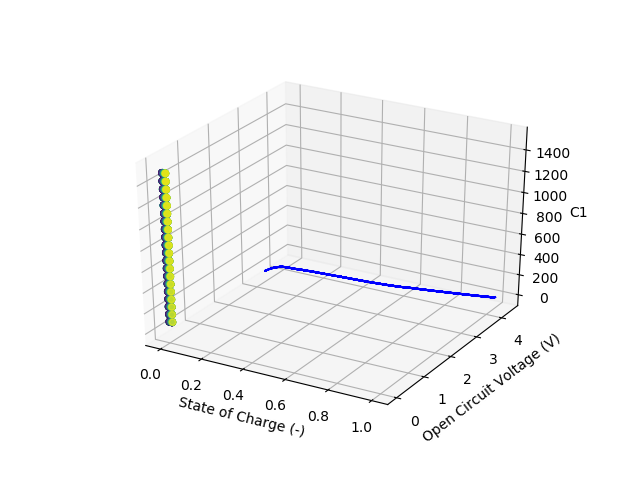

0.07833662329889819
(6, 11, 5)
0.07833662329889819
0.004736842105263157
0.008684210526315789
468.42105263157896


In [15]:
'''
==============
3D scatterplot
==============

Demonstration of a basic scatterplot in 3D.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
c = [i for i in range(0,99)]
m = 'o'
xs,ys,zs = np.meshgrid(R0list,R1list,C1list)
ax.scatter(xs, ys, zs, c=np.reshape(sk,(8000,)), marker=m)

ax.set_xlabel('R0')
ax.set_ylabel('R1')
ax.set_zlabel('C1')

plt.show()
print(np.min(sk))
print(np.unravel_index(np.argmin(sk),np.shape(sk)))
print(sk[6,11,5])
print(R0list[6])
print(R1list[11])
print(C1list[5])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm 

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

for kc in range(len(C1list)):
    plt.figure()
    plt.contourf(R1list,R0list,sk[:,:,kc])
    plt.colorbar()
    plt.xlabel('R1')
    plt.ylabel('R0')
    plt.title(f'C1 = {C1list[kc]}')

In [ ]:
vtilda = vsim - curve.OCVfromSOC(battery.simz[1:])

plt.figure()
plt.plot(time,vtilda)
plt.xlabel('time (s)')
# plt.ylabel('v_{load}-OCV', usetex=True)
plt.grid()
plt.show()

# Kalman Filter

In [ ]:
import filterpy
from filterpy.kalman import KalmanFilter

In [ ]:
dim_x = 2 # number of states
dim_z = 1 # number of outputs
kf = KalmanFilter(2,1)
battery.statespace(battery.simdt)
kf.F = battery.A 
kf.B = battery.B 

In [ ]:
xplus0 = np.array([[z0],[0.]]) # is a stack of 2x1 arrays = a 2xk array
covxplus0 = np.array([[1e-4,0.],[0., .1]]) # is a stack of 2x2 arrays

covw = np.array([[0.05, 0.],[0., 0.]]) # is a constant 2x2 array
covv = 0.5017 # is a constant 1x1 array

xminus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covmxminus = np.array([]) # is a stack of 2x2 arrays
yhat = np.array([]) # is a stack of 1x1 arrays = a 1-D array
xplus = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covxplus = np.array([]) # is a stack of 2x2 arrays
covxy = np.array([]) # is a stack of 2x1 arrays = a 2xk array
covy = np.array([]) # is a stack of 1x1 arrays = a 1-D array
L = np.array([]) # is a stack of stack of 2x1 arrays = a 1-D array

u = current # is a stack of 1x1 arrays = a 1-D array
y = voltage # is a stack of 1x1 arrays = a 1-D array

kfbat = Thevenin(z0,Q,curve,R0,R1,C1)

In [ ]:
n = 10
for k in range(len(y[:n+1])):
    #print(f'\n New iteration k={k}')
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a posteriori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a posteriori estimated value of i1 : {xplus[1,-1]}')
    
    if k == 0: 
        kfbat.reset(R0,R1,C1,xplus0[0])
    else: 
        kfbat.reset(R0,R1,C1,xplus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    #print(f'Matrix C is {kfbat.C}')
    
    
    # 1 : Prediction update
    
    # 1a State prediction
    
    if k==0: 
        alpha = np.reshape(kfbat.A@xplus0,(2,1))
        xminus = alpha
    
    else : 
        alpha = np.reshape(kfbat.A@xplus[:,k-1],(2,1))
        beta = kfbat.B*u[k-1]
        xminus = np.concatenate([xminus, alpha + beta],axis=1)
    
    
    #if k==0:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus0[0]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus0[1]}')
    #else:
        #print(f'Real value of z : {battery.simz[k]}, a priori estimated value of z : {xplus[0,-1]}')
        #print(f'Real value of i1 : {battery.simi1[k]}, a priori estimated value of i1 : {xplus[1,-1]}')
    
    
    #print(f'xminus is {np.shape(xminus)}, should be 2x{k+1}')
    
    kfbat.reset(R0,R1,C1,xminus[0,-1])
    kfbat.statespace(battery.simdt)
    
    
    # 1b State covariance a priori
    
    if k==0 :
        covxminus = kfbat.A@covxplus0@kfbat.A.T + covw
    elif k==1: 
        covxminus = np.dstack([covxminus,kfbat.A@covxplus@kfbat.A.T + covw])
    else :
        covxminus = np.dstack([covxminus,kfbat.A@covxplus[:,:,-1]@kfbat.A.T + covw])
    #print(f'covxminus = {covxminus}')    
    #print(f'covxminus is {np.shape(covxminus)}, should be 2x2x{k+1}')
    
    # 1c : Output predicition
    
    if k==0: 
        yhat = kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]
    else : 
        yhat = np.concatenate([yhat,kfbat.OCVcurve.OCVfromSOC(xminus[0,k]) - R1*xminus[1,k] + kfbat.D*u[k]]) 
    #print(f'y : {y[k]}')  
    #print(f'yhat : {yhat[k]}')
    #print(f'yhat is {np.shape(yhat)}, should be {k+1}')
    
    # 2 : Measurement update
    
    # 2a Kalman gain computation
    
    if k==0:
        covxy = np.reshape(covxminus@kfbat.C.T,(2,1))
        covy = np.reshape(kfbat.C@covxminus@kfbat.C.T + covv,1)
        L = covxy/covy
    else : 
        covxy = np.concatenate([covxy,np.reshape(covxminus[:,:,k]@kfbat.C.T,(2,1))],axis=1)
        #print(f'covxy is {np.shape(covxy)}, should be {2,k+1}')
        #print(np.shape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv))
        covy = np.concatenate([covy,np.reshape(kfbat.C@covxminus[:,:,k]@kfbat.C.T + covv,1)])
        L = np.concatenate([L,covxy/covy],axis=1)
    #print(f'covy is {np.shape(covy)}, should be {k+1}')
    
    #print(f'covxy = {covxy[:,k]}')      
    #print(f'Lk={np.reshape(L[:,-1],(2,1))}')
    
    #print(f'L is {np.shape(L)}, should be 2x{k+1}')
          
    # 2b State estimate correction
          
    inno = y[k] - yhat[k]
    #print(f'Innovation : {inno}')
    
    if k==0:
        xplus = xplus0  
    else : 
        xplus = np.concatenate([xplus,np.reshape(xminus[:,k],(2,1)) + np.reshape(L[:,k]*inno,(2,1))],axis=1) 
    #print(f'xplus is {np.shape(xplus)}, should be 2x{k+1}')
    
    # 2c State covariance a posteriori 
    if k==0: 
          covxplus = covxminus - L*kfbat.C@covxminus
    else :
        covxplus = np.dstack([covxplus,covxminus[:,:,k] - L[:,k]*kfbat.C@covxminus[:,:,-1]])
        #print(covxplus[:,:,k])
    #print(f'covxplus is {np.shape(covxplus)}, should be 2x2x{k+1}')    
    

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure()
plt.subplot(311)
plt.plot(battery.simz[:n+1],'.-')
plt.plot(xminus[0,:],linestyle='-.')
plt.plot(xminus[0,:]+covxminus[0,0,:],color=colors[1],linewidth=0.7)
plt.plot(xminus[0,:]-covxminus[0,0,:],color=colors[1],linewidth=0.7)
#plt.plot(xplus[0,:],'.-')
plt.ylabel('state of charge')
plt.grid()
plt.subplot(312)
plt.plot(battery.simi1[:n+1],'.-',label='sim')
plt.plot(xplus[1,:],'-.',color = colors[1],label='KF')
plt.plot(xplus[1,:]+covxplus[1,1,:],color=colors[1],linewidth=0.7)
plt.plot(xplus[1,:]-covxplus[1,1,:],color=colors[1],linewidth=0.7)
plt.legend()
plt.ylabel('current through R1')
plt.grid()
plt.subplot(313)
plt.plot(battery.simv[:n+1],'.-',label='sim')
plt.plot(yhat,'-.')
plt.plot(yhat+covy,color=colors[1],linewidth=0.7)
plt.plot(yhat-covy,color=colors[1],linewidth=0.7)
plt.xlabel('iterations')
plt.ylabel('terminal voltage')
plt.grid()

In [ ]:
norm_covxminus = []
norm_covxplus = []
for k in range(np.shape(covxminus)[2]):
    norm_covxminus.append(np.linalg.eig(covxminus[:,:,k])[0])
    norm_covxplus.append(np.linalg.eig(covxplus[:,:,k])[0])    

In [ ]:
plt.figure()
plt.subplot(311)
plt.plot(norm_covxminus,':',label='covxminus')
plt.plot(norm_covxplus,label='covxplus',alpha=0.7)
plt.legend()
plt.grid()
plt.subplot(312)
plt.plot(covy,label='covy')
plt.legend()
plt.grid()
plt.subplot(313)
plt.plot(covxy[0,:],label='cov(z,y)')
plt.plot(covxy[1,:],label='cov(i1,y)')
plt.legend()
plt.grid()
plt.show()

The second eigenvalue of covx does not change with the meausrement update, while the first one remains almost constant, even if systematically downed by 0.9 by the meausrement update.

In [ ]:
battery.kfinit()
plt.figure()
plt.plot(voltage)
plt.grid()
for k in range(len(current)):
    battery.kfupdate(current[k],voltage[k])
    plt.plot(k,battery.yhat,'r.',markersize=.4)
    #print(battery.yhat)


In [ ]:
battery.kfinit()
plt.figure()
plt.grid()
for k in range(len(current)):
    battery.kfupdate(current[k],vsim[k])
    plt.plot(k,battery.xhat[0],'r.',markersize=.4)
    #print(battery.yhat)
